In [1]:
import pandas as pd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [2]:
year = 20
df_csv = f"./output/df{year}_pred_lastname.csv"
state_csv = f"./data/df20_state_stats.csv"
cands_csv = f"./data/CampaignFin{year}/cands{year}.txt"

In [3]:
lf = (
        pl.scan_csv(
            df_csv,
            has_header=True,
            ignore_errors=True
        )
    )

In [4]:
df = lf.collect(streaming=True)
print(df.head(10))

shape: (10, 22)
┌────────┬─────────────┬─────────────┬────────────┬───┬───────────┬──────────┬────────────┬────────┐
│ dummy1 ┆ dummy2      ┆ contrib_id  ┆ name       ┆ … ┆ firstname ┆ lastname ┆ name_new   ┆ ethnic │
│ ---    ┆ ---         ┆ ---         ┆ ---        ┆   ┆ ---       ┆ ---      ┆ ---        ┆ ---    │
│ i64    ┆ i64         ┆ str         ┆ str        ┆   ┆ str       ┆ str      ┆ str        ┆ str    │
╞════════╪═════════════╪═════════════╪════════════╪═══╪═══════════╪══════════╪════════════╪════════╡
│ 2020   ┆ 40302202012 ┆ p0004869853 ┆ LONNBERG,  ┆ … ┆ carl      ┆ lonnberg ┆ carl       ┆ not    │
│        ┆ 14334986    ┆             ┆ CARL       ┆   ┆           ┆          ┆ lonnberg   ┆        │
│ 2020   ┆ 40302202012 ┆ k0001516259 ┆ LOVO,      ┆ … ┆ mario     ┆ lovo     ┆ mario lovo ┆ not    │
│        ┆ 14334988    ┆             ┆ MARIO      ┆   ┆           ┆          ┆            ┆        │
│ 2020   ┆ 40302202012 ┆ h3003526289 ┆ LOGUE,     ┆ … ┆ katherine ┆ logue  

In [5]:
print(df.columns)

['dummy1', 'dummy2', 'contrib_id', 'name', 'recip_id', 'orgname', 'ultorg', 'realcode', 'amount', 'street', 'city', 'state', 'zip', 'recipcode', 'type', 'gender', 'occupation', 'employer', 'firstname', 'lastname', 'name_new', 'ethnic']


In [6]:
print(df["state"].value_counts().sort(by="count", descending=True))

shape: (95, 2)
┌───────┬─────────┐
│ state ┆ count   │
│ ---   ┆ ---     │
│ str   ┆ u32     │
╞═══════╪═════════╡
│ CA    ┆ 5770396 │
│ TX    ┆ 2630388 │
│ NY    ┆ 2453987 │
│ FL    ┆ 2158017 │
│ PA    ┆ 1266349 │
│ …     ┆ …       │
│ WE    ┆ 1       │
│ NT    ┆ 1       │
│ SE    ┆ 1       │
│ OF    ┆ 1       │
│ RM    ┆ 1       │
└───────┴─────────┘


In [ ]:
state_stats = (
    lf.collect(streaming=True).group_by("state")
    .agg(
        pl.col("amount").mean().alias("avg_amount"),
        pl.col("amount").median().alias("med_amount"),
        pl.col("amount").count().alias("total_donations"),
        pl.col("amount").filter(pl.col("ethnic") == "ind").mean().alias("avg_amount_indian"),
        pl.col("amount").filter(pl.col("ethnic") == "ind").median().alias("med_amount_indian"),
        pl.col("amount").filter(pl.col("ethnic") == "ind").count().alias("indian_donations")
    )
    .sort("avg_amount", descending=True)
)

In [ ]:
df.filter(pl.col("state") == "TA")

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,amount,street,city,state,zip,recipcode,type,gender,occupation,employer,firstname,lastname,name_new,ethnic,region,census_region
i64,i64,str,str,str,str,str,str,f64,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str
2020,4032820201718323278,"""r0002345953 ""","""YANG, DAVID""","""N00042308""","""Cid Group""",null,"""F2500""",1000.0,null,"""TAIPEI CITY""","""TA""",null,"""DL""","""15E""","""M""","""VENTURE CAPITAL""","""THE CID GROUP""","""david""","""yang""","""david yang""","""not""","""TA""","""TA"""
2020,4032820201718323280,"""r0002345953 ""","""YANG, DAVID""","""N00042308""","""Cid Group""",null,"""F2500""",1000.0,null,"""TAIPEI CITY""","""TA""",null,"""DL""","""15E""","""M""","""VENTURE CAPITAL""","""THE CID GROUP""","""david""","""yang""","""david yang""","""not""","""TA""","""TA"""


In [ ]:
state_stats.sort(by="total_donations", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,u32,f64,f64,u32
"""CA""",373.445931,35.0,5770396,640.890275,50.0,37357
"""TX""",302.284825,42.0,2630388,863.884302,91.0,15212
"""NY""",868.090588,35.0,2453987,543.587322,50.0,17653
"""FL""",325.839634,37.0,2158017,820.30152,56.0,8026
"""PA""",201.065893,37.0,1266349,492.952629,50.0,5383
"""WA""",202.424907,27.0,1263163,470.059176,50.0,8669
"""IL""",338.39925,35.0,1235037,366.057881,50.0,8241
"""VA""",445.251737,40.0,1213638,424.417872,50.0,6916
"""MA""",319.88028,35.0,1138194,664.219606,58.0,5692


In [25]:
# state_stats.write_csv("./output/df20_state_stats.csv")
state_stats = pd.read_csv(state_csv)
state_stats = pl.from_pandas(state_stats)
state_stats.head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,i64,f64,f64,i64
"""DC""",1655.257612,75.0,484135,265.288361,69.0,3454
"""WY""",1287.410867,50.0,63697,3159.351852,45.0,54
"""TA""",1000.0,1000.0,2,null,1000.0,0
"""NY""",812.532676,30.0,2578261,575.373986,27.0,18244
"""NT""",750.0,750.0,1,null,750.0,0
""" """,614.574223,50.0,10071,3652.508475,50.0,59
"""NV""",604.844376,27.0,350518,358.199288,28.0,562
"""IR""",580.62963,500.0,81,null,500.0,0
"""99""",571.861111,245.0,36,null,240.0,0


In [26]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [27]:
import geopandas as gpd

# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats.to_pandas(), on="state", how="left")

In [28]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")
gdf_merged.head()

,iso_3166_2,name,geometry,state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations,Year,Name,Code,Indian Pop,Census Pop,Share
0,US-MN,Minnesota,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",MN,189.616199,27.0,610793,197.414179,27.0,1608,2020,Minnesota,MN,42943,5710735,0.751970
1,US-MT,Montana,"POLYGON ((-116.04823 49.00037, -113.0595 49.00...",MT,215.818654,35.0,136005,152.315789,35.0,76,2020,Montana,MT,756,1087230,0.069535
2,US-ND,North Dakota,"POLYGON ((-97.22894 49.00089, -97.21414 48.902...",ND,256.573885,35.0,54842,45.500000,35.0,76,2020,North Dakota,ND,1060,779563,0.135974
3,US-ID,Idaho,"POLYGON ((-116.04823 49.00037, -115.9678 47.95...",ID,179.141515,27.0,160654,1289.371622,27.0,148,2020,Idaho,ID,3068,1849415,0.165890
4,US-WA,Washington,"POLYGON ((-117.03143 48.99931, -117.02665 47.7...",WA,184.875543,27.0,1321049,582.681178,27.0,6248,2020,Washington,WA,145102,7727209,1.877806


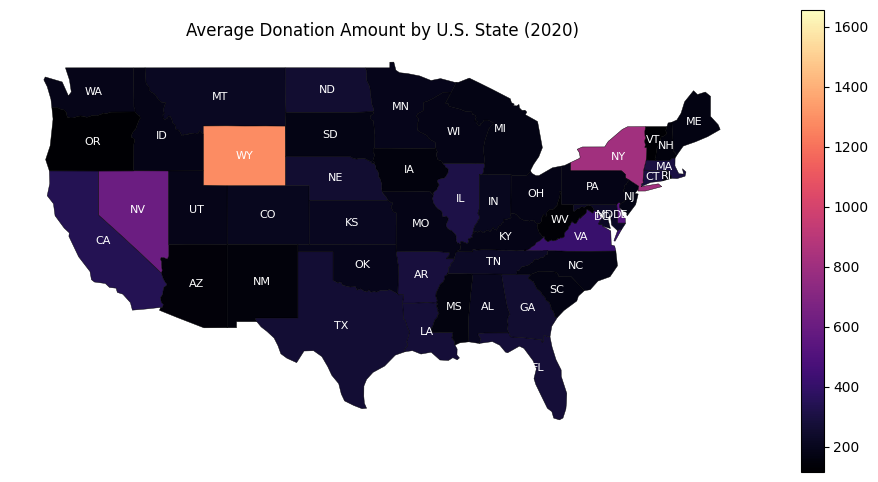

In [29]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [30]:
state_stats.sort(by="avg_amount", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,i64,f64,f64,i64
"""DC""",1655.257612,75.0,484135,265.288361,69.0,3454
"""WY""",1287.410867,50.0,63697,3159.351852,45.0,54
"""TA""",1000.0,1000.0,2,null,1000.0,0
"""NY""",812.532676,30.0,2578261,575.373986,27.0,18244
"""NT""",750.0,750.0,1,null,750.0,0
""" """,614.574223,50.0,10071,3652.508475,50.0,59
"""NV""",604.844376,27.0,350518,358.199288,28.0,562
"""IR""",580.62963,500.0,81,null,500.0,0
"""99""",571.861111,245.0,36,null,240.0,0


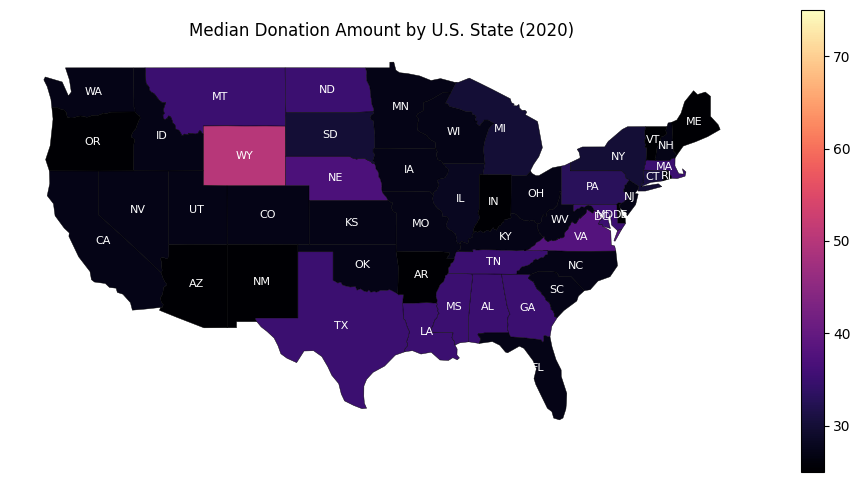

In [31]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [32]:
state_stats.sort(by="med_amount", descending=True)[20:30]

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,i64,f64,f64,i64
"""TY""",100.0,100.0,2,null,100.0,0
"""TO""",87.8,100.0,30,null,100.0,0
"""DC""",1655.257612,75.0,484135,265.288361,69.0,3454
"""PW""",136.117647,60.0,17,null,60.0,0
"""WY""",1287.410867,50.0,63697,3159.351852,45.0,54
""" """,614.574223,50.0,10071,3652.508475,50.0,59
"""GU""",409.528988,50.0,2501,null,50.0,0
"""VI""",331.280381,50.0,3777,146.681818,35.0,22
"""SH""",63.888889,50.0,9,null,50.0,0


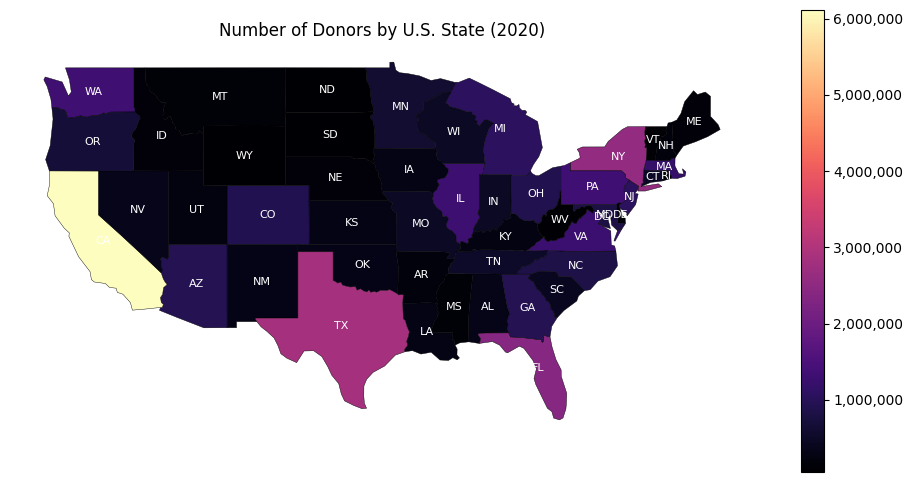

In [33]:
# import funcformatter


fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="total_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [34]:
state_stats.sort(by="total_donations", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,i64,f64,f64,i64
"""CA""",341.106825,27.0,6113724,769.552688,27.0,37010
"""TX""",262.534747,35.0,2829582,663.04803,35.0,14491
"""NY""",812.532676,30.0,2578261,575.373986,27.0,18244
"""FL""",276.903425,27.0,2388060,894.07298,27.0,7687
"""PA""",180.913338,33.0,1340512,250.18215,33.0,4661
"""WA""",184.875543,27.0,1321049,582.681178,27.0,6248
"""IL""",308.65748,28.0,1306210,468.352097,27.0,8296
"""VA""",414.919981,38.0,1272967,457.235434,38.0,7157
"""MA""",297.012903,35.0,1182558,887.068776,31.0,5627


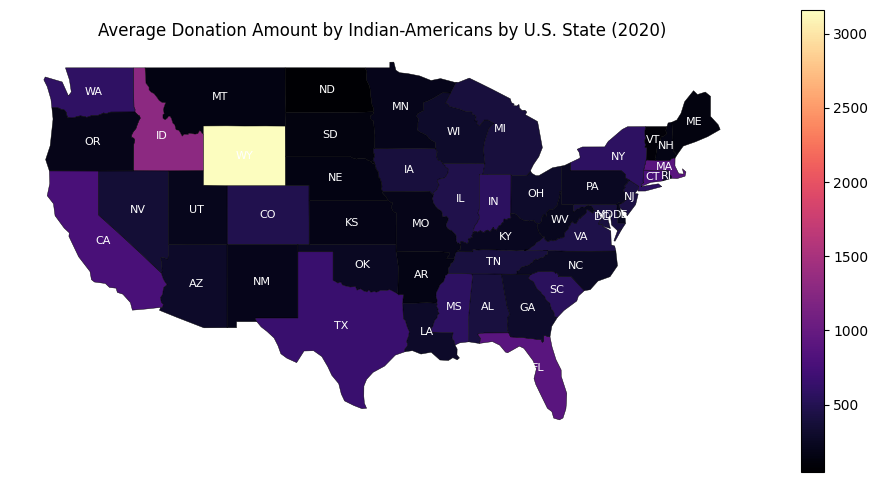

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Average Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [36]:
state_stats.sort(by="avg_amount_indian", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,i64,f64,f64,i64
"""TA""",1000.0,1000.0,2,null,1000.0,0
"""NT""",750.0,750.0,1,null,750.0,0
"""IR""",580.62963,500.0,81,null,500.0,0
"""99""",571.861111,245.0,36,null,240.0,0
"""MH""",570.75,154.0,4,null,154.0,0
"""FM""",522.333333,437.5,6,null,437.5,0
"""MB""",505.875,275.0,8,null,275.0,0
"""RM""",500.0,500.0,1,null,500.0,0
"""GU""",409.528988,50.0,2501,null,50.0,0


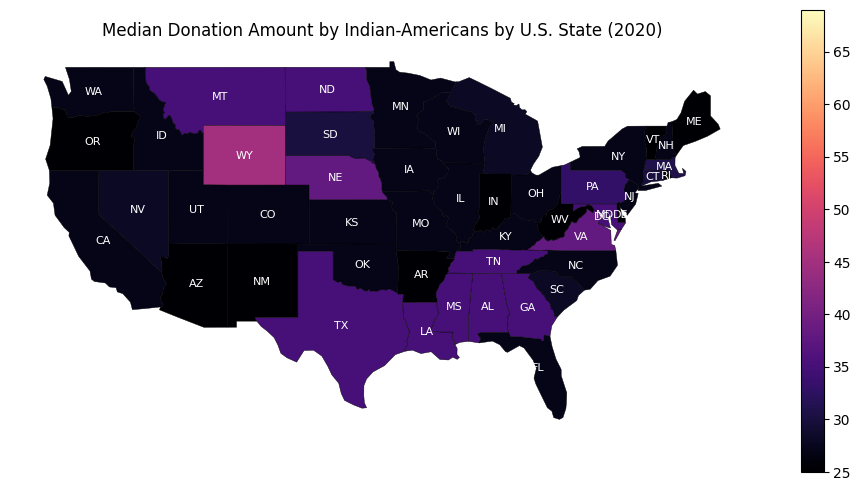

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Median Donation Amount by Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [38]:
state_stats.sort(by="med_amount_indian", descending=True)[39:49]

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,i64,f64,f64,i64
"""GA""",256.7374,35.0,933707,300.386648,35.0,4239
"""ND""",256.573885,35.0,54842,45.5,35.0,76
"""MD""",226.050623,35.0,795407,401.019188,35.0,4534
"""TN""",224.370001,35.0,512088,409.453823,35.0,1007
"""MT""",215.818654,35.0,136005,152.315789,35.0,76
"""AL""",207.62731,35.0,331917,407.151852,35.0,540
"""MS""",161.62544,35.0,144153,580.1,35.0,170
"""PA""",180.913338,33.0,1340512,250.18215,33.0,4661
"""AK""",144.778498,33.0,122071,106.393443,33.0,122


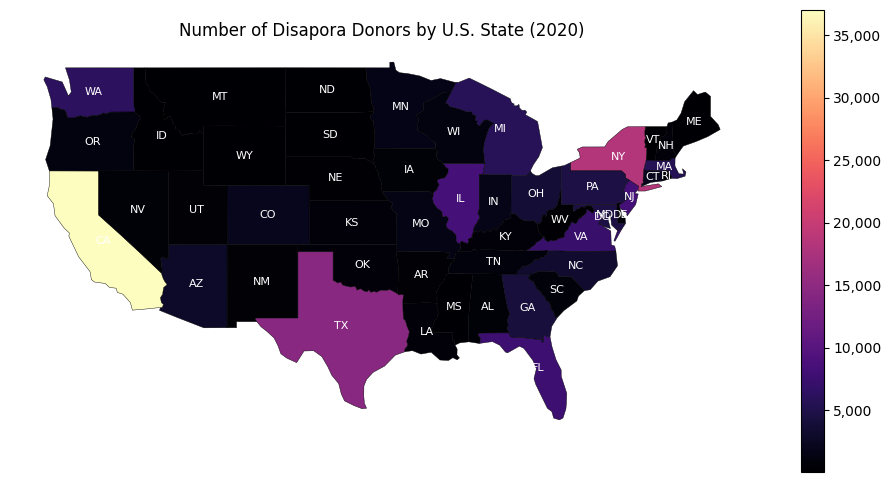

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="indian_donations",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Number of Disapora Donors by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [40]:
state_stats.sort(by="indian_donations", descending=True).head(10)

state,avg_amount,med_amount,total_donations,avg_amount_indian,med_amount_indian,indian_donations
str,f64,f64,i64,f64,f64,i64
"""CA""",341.106825,27.0,6113724,769.552688,27.0,37010
"""NY""",812.532676,30.0,2578261,575.373986,27.0,18244
"""TX""",262.534747,35.0,2829582,663.04803,35.0,14491
"""IL""",308.65748,28.0,1306210,468.352097,27.0,8296
"""NJ""",172.743402,27.0,1058393,426.06907,27.0,8238
"""FL""",276.903425,27.0,2388060,894.07298,27.0,7687
"""VA""",414.919981,38.0,1272967,457.235434,38.0,7157
"""WA""",184.875543,27.0,1321049,582.681178,27.0,6248
"""MI""",176.103624,30.0,1057065,390.507178,28.0,5712


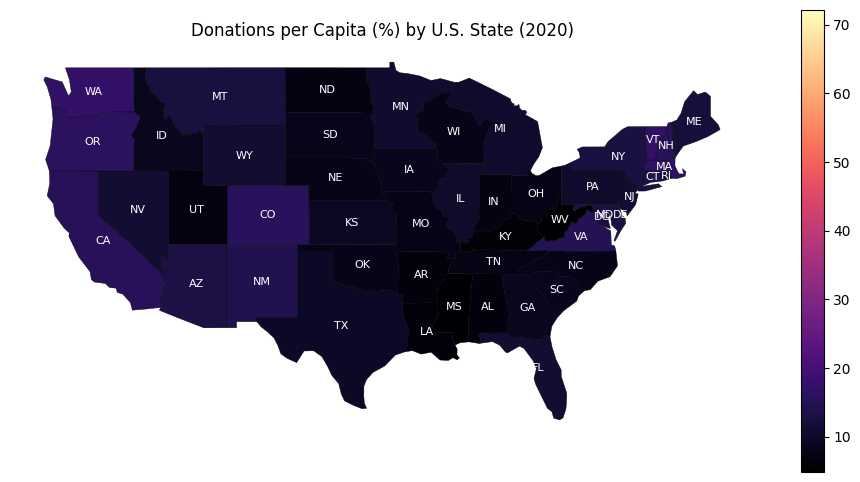

In [66]:
gdf_merged["don_per_capita"] = gdf_merged["total_donations"] / gdf_merged["Census Pop"] * 100
gdf_merged["don_per_capita_indian"] = gdf_merged["indian_donations"] / gdf_merged["Indian Pop"] * 100

fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Donations per Capita (%) by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [67]:
gdf_merged.sort_values(by="don_per_capita", ascending=False)[["name", "state", "total_donations", "indian_donations", "don_per_capita", "don_per_capita_indian"]].head(10)

,name,state,total_donations,indian_donations,don_per_capita,don_per_capita_indian
42,District of Columbia,DC,484135,3454,72.160193,1.953963
4,Washington,WA,1321049,6248,17.096069,4.305937
26,Vermont,VT,109496,169,17.029536,8.761016
23,Massachusetts,MA,1182558,5627,16.906733,4.419052
10,Oregon,OR,681431,1200,16.057175,4.075672
7,Colorado,CO,912695,2012,15.771119,6.008481
6,California,CA,6113724,37010,15.469183,4.322689
24,New Hampshire,NH,209755,730,15.213352,6.809066
38,Virginia,VA,1272967,7157,14.737483,4.476846
9,New Mexico,NM,301482,438,14.230206,9.100353


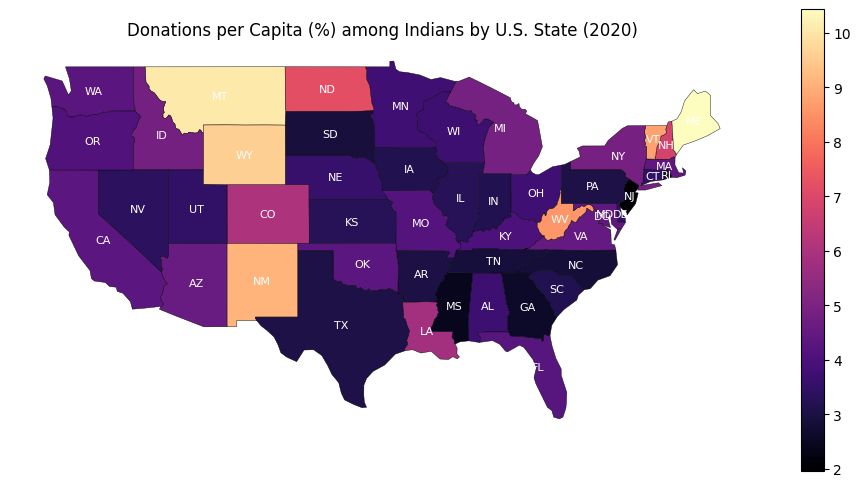

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Donations per Capita (%) among Indians by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [71]:
gdf_merged.sort_values(by="don_per_capita_indian", ascending=False)[["name", "state", "total_donations", "indian_donations", "don_per_capita", "don_per_capita_indian"]].head(10)

,name,state,total_donations,indian_donations,don_per_capita,don_per_capita_indian
47,Maine,ME,164582,175,12.061080,10.435301
1,Montana,MT,136005,76,12.509313,10.052910
12,Wyoming,WY,63697,54,11.026328,9.591474
9,New Mexico,NM,301482,438,14.230206,9.100353
26,Vermont,VT,109496,169,17.029536,8.761016
40,West Virginia,WV,90549,248,5.053956,8.557626
2,North Dakota,ND,54842,76,7.034967,7.169811
24,New Hampshire,NH,209755,730,15.213352,6.809066
7,Colorado,CO,912695,2012,15.771119,6.008481
20,Louisiana,LA,279707,728,6.012229,5.821206


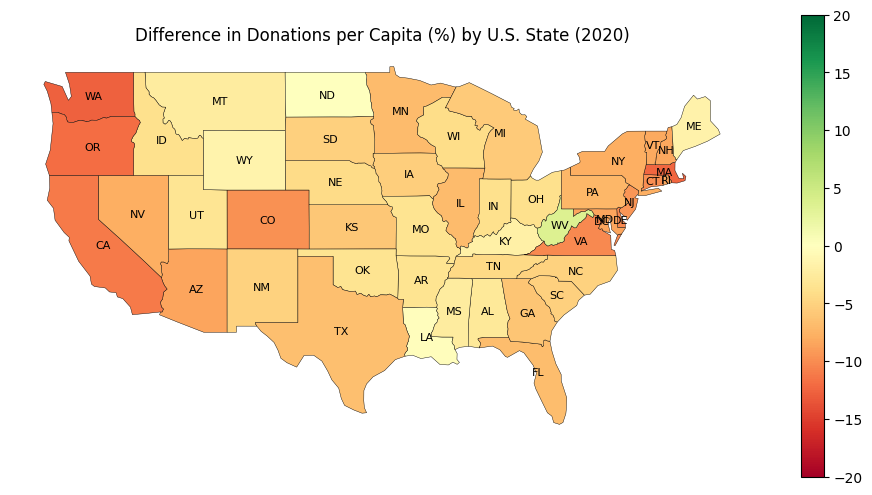

In [76]:
gdf_merged["don_per_capita_diff"] = gdf_merged["don_per_capita_indian"] - gdf_merged["don_per_capita"]

fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-20,
    vmax=20
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")

plt.title("Difference in Donations per Capita (%) by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [77]:
gdf_merged.sort_values(by="don_per_capita_diff", ascending=False)[["name", "state", "total_donations", "indian_donations", "don_per_capita_diff", "don_per_capita", "don_per_capita_indian"]].head(10)

,name,state,total_donations,indian_donations,don_per_capita_diff,don_per_capita,don_per_capita_indian
40,West Virginia,WV,90549,248,3.503670,5.053956,8.557626
2,North Dakota,ND,54842,76,0.134844,7.034967,7.169811
20,Louisiana,LA,279707,728,-0.191023,6.012229,5.821206
12,Wyoming,WY,63697,54,-1.434853,11.026328,9.591474
47,Maine,ME,164582,175,-1.625779,12.061080,10.435301
34,Kentucky,KY,264668,659,-1.894073,5.870660,3.976587
1,Montana,MT,136005,76,-2.456403,12.509313,10.052910
30,Mississippi,MS,144153,170,-2.475377,4.872444,2.397067
27,Alabama,AL,331917,540,-2.914462,6.594691,3.680229
11,Utah,UT,226605,417,-3.423954,6.900112,3.476159


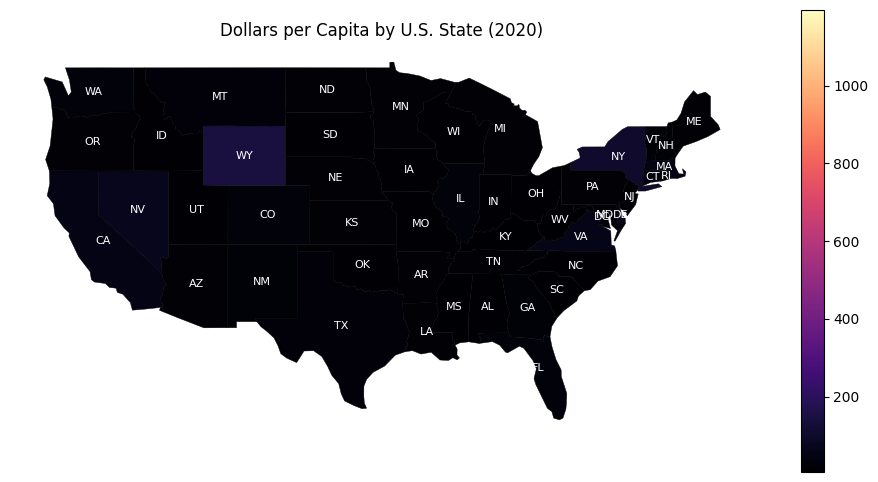

In [45]:
gdf_merged["dollars_per_capita"] = (gdf_merged["total_donations"] * gdf_merged["avg_amount"]) / gdf_merged["Census Pop"]
gdf_merged["dollars_per_capita_indian"] = (gdf_merged["indian_donations"] * gdf_merged["avg_amount_indian"]) / gdf_merged["Indian Pop"]

fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Dollars per Capita by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [ ]:
gdf_merged.sort_values(by="dollars_per_capita", ascending=False)[["name", "state", "total_donations", "indian_donations", "dollars_per_capita", "dollars_per_capita_indian"]].head(10)

,name,state,total_donations,indian_donations,dollars_per_capita,dollars_per_capita_indian
42,District of Columbia,DC,484135,3454,1194.437082,5.183635
12,Wyoming,WY,63697,54,141.954141,303.028419
45,New York,NY,2578261,18244,104.198134,28.050299
41,Delaware,DE,134994,555,71.794305,7.688542
8,Nevada,NV,350518,562,68.017673,12.023413
38,Virginia,VA,1272967,7157,61.148760,20.469728
6,California,CA,6113724,37010,52.766439,33.265371
23,Massachusetts,MA,1182558,5627,50.215178,39.200031
22,Connecticut,CT,481682,2147,39.582164,26.779343
7,Colorado,CO,912695,2012,32.376537,28.866452


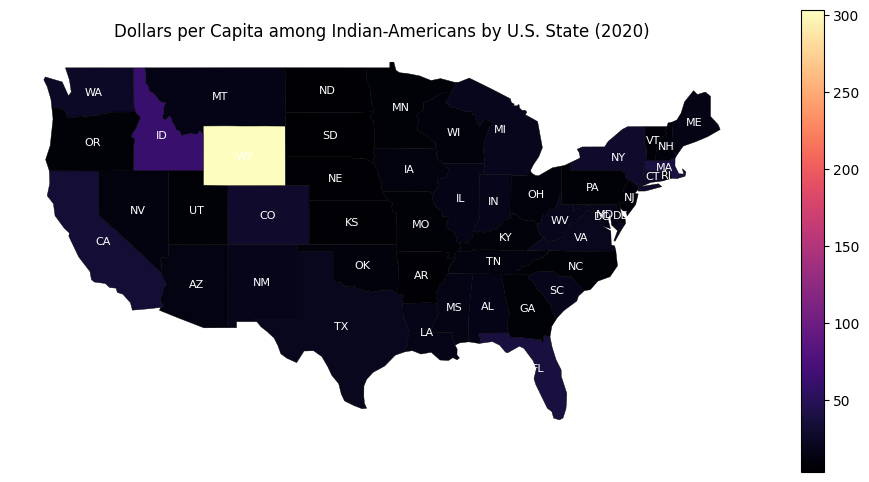

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita_indian",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")

plt.title("Dollars per Capita among Indian-Americans by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [59]:
gdf_merged.sort_values(by="dollars_per_capita_indian", ascending=False)[["name", "state", "Indian Pop", "total_donations", "indian_donations", "dollars_per_capita", "dollars_per_capita_indian"]].head(10)

,name,state,Indian Pop,total_donations,indian_donations,dollars_per_capita,dollars_per_capita_indian
12,Wyoming,WY,563,63697,54,141.954141,303.028419
3,Idaho,ID,3068,160654,148,15.561570,62.199153
23,Massachusetts,MA,127335,1182558,5627,50.215178,39.200031
28,Florida,FL,181805,2388060,7687,30.625274,37.802805
6,California,CA,856180,6113724,37010,52.766439,33.265371
7,Colorado,CO,33486,912695,2012,32.376537,28.866452
45,New York,NY,374225,2578261,18244,104.198134,28.050299
22,Connecticut,CT,61888,481682,2147,39.582164,26.779343
4,Washington,WA,145102,1321049,6248,31.606451,25.089882
38,Virginia,VA,159867,1272967,7157,61.148760,20.469728


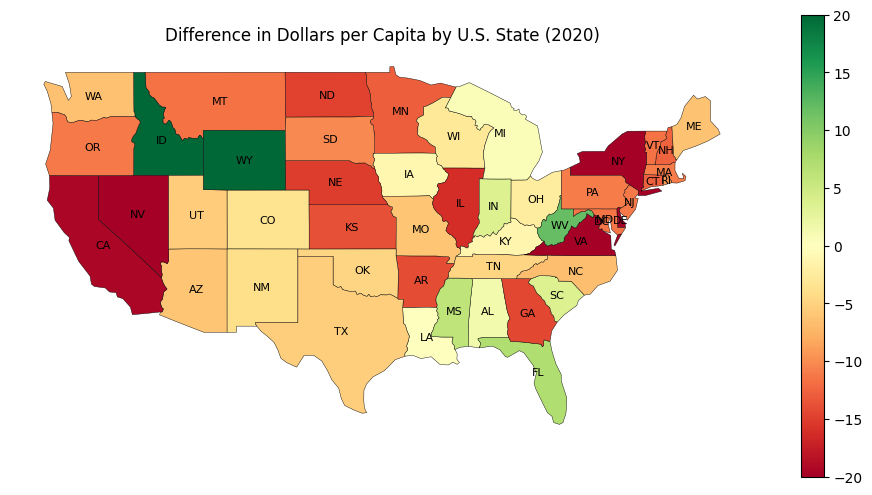

In [84]:
gdf_merged["dollars_per_capita_diff"] = gdf_merged["dollars_per_capita_indian"] - gdf_merged["dollars_per_capita"]

fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita_diff",
    cmap="RdYlGn",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-20,
    vmax=20
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="black")

plt.title("Difference in Dollars per Capita by U.S. State (2020)")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [83]:
gdf_merged.sort_values(by="dollars_per_capita_diff", ascending=False)[["name", "state", "total_donations", "indian_donations", "dollars_per_capita_diff", "dollars_per_capita", "dollars_per_capita_indian"]].head(10)

,name,state,total_donations,indian_donations,dollars_per_capita_diff,dollars_per_capita,dollars_per_capita_indian
12,Wyoming,WY,63697,54,161.074278,141.954141,303.028419
3,Idaho,ID,160654,148,46.637583,15.561570,62.199153
40,West Virginia,WV,90549,248,11.989925,6.618425,18.608351
28,Florida,FL,2388060,7687,7.177531,30.625274,37.802805
30,Mississippi,MS,144153,170,6.030278,7.875108,13.905386
33,Indiana,IN,478605,1664,3.551523,14.155761,17.707284
31,South Carolina,SC,431411,836,3.472405,13.956796,17.429201
27,Alabama,AL,331917,540,1.291741,13.692380,14.984120
48,Michigan,MI,1057065,5712,0.493655,18.480936,18.974591
20,Louisiana,LA,279707,728,0.052907,16.412230,16.465137


In [ ]:
cands_lf = (
        pl.scan_csv(
            cands_csv,
            separator=',', 
            quote_char='|', 
            encoding='utf8-lossy', 
            has_header=False,
            new_columns=['dummy1', 'id', 'recip_id', 'name', 'party', 
                        'seat', 'dummy4', 'dummy5', 'dummy6', 'dummy7', 
                        'dummy8', 'dummy9'],
            ignore_errors=True
        )
        .select(['id', 'recip_id', 'name', 'party', 'seat', 'dummy4', 'dummy5', 'dummy6', 'dummy7', 
                        'dummy8', 'dummy9'])
    )
cands = cands_lf.collect()
print(cands.head(10))

shape: (10, 11)
┌───────────┬───────────┬──────────────────────┬───────┬───┬────────┬────────┬────────┬────────┐
│ id        ┆ recip_id  ┆ name                 ┆ party ┆ … ┆ dummy6 ┆ dummy7 ┆ dummy8 ┆ dummy9 │
│ ---       ┆ ---       ┆ ---                  ┆ ---   ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ str       ┆ str       ┆ str                  ┆ str   ┆   ┆ str    ┆ str    ┆ str    ┆ str    │
╞═══════════╪═══════════╪══════════════════════╪═══════╪═══╪════════╪════════╪════════╪════════╡
│ H0AK00105 ┆ N00039029 ┆ Thomas Lamb (I)      ┆ I     ┆ … ┆ Y      ┆ C      ┆ 3N     ┆        │
│ H0AK00113 ┆ N00047445 ┆ Ray Sean Tugatuk (D) ┆ D     ┆ … ┆ Y      ┆ C      ┆ DL     ┆        │
│ H0AK01046 ┆ N00047447 ┆ Thomas Catalano (3)  ┆ 3     ┆ … ┆        ┆        ┆ 3N     ┆        │
│ H0AL01055 ┆ N00044245 ┆ Jerry Carl (R)       ┆ R     ┆ … ┆ Y      ┆ O      ┆ RW     ┆        │
│ H0AL01063 ┆ N00044288 ┆ Wes Lambert (R)      ┆ R     ┆ … ┆ Y      ┆ O      ┆ RL     ┆        │
│ H0AL01071 ┆ 

In [ ]:
df.filter(pl.col("recip_id") == "N00044839").head(5)

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,amount,street,city,state,zip,recipcode,type,gender,occupation,employer,firstname,lastname,name_new,ethnic,region,census_region
i64,i64,str,str,str,str,str,str,f64,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str
2020,4030220201222914336,"""r0017002134 ""","""PETTIFORD, HELEN""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""RALEIGH""","""NC""",27604.0,"""DL""","""24T""","""F""","""TEACHER""","""THE MAGELLAN CHARTER SCHOOL""","""helen""","""pettiford""","""helen pettiford""","""not""","""South""","""South Atlantic"""
2020,4030220201223662421,"""r0019074362 ""","""OLIVENCIA-SIMMONS, IVELISSE""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""CHARLOTTE""","""NC""",28277.0,"""DL""","""24T""","""F""","""NOT EMPLOYED""","""NOT EMPLOYED""","""ivelisse""","""olivencia-simmons""","""ivelisse olivencia-simmons""","""not""","""South""","""South Atlantic"""
2020,4030220201223647042,"""r0001569100 ""","""LEMMON, CHRIS""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""MOSELEY""","""VA""",23120.0,"""DL""","""24T""","""M""","""PROFESSOR""","""VCU""","""chris""","""lemmon""","""chris lemmon""","""not""","""South""","""South Atlantic"""
2020,4030220201214499368,"""m0001668516 ""","""LAMBERT, PHILLIP""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""MOBILE""","""AL""",36608.0,"""DL""","""24T""","""M""","""SUPERVISOR""","""STATE OF AL DDS""","""phillip""","""lambert""","""phillip lambert""","""not""","""South""","""Deep South"""
2020,4032420201713973997,"""p0003376821 ""","""VOIT, LAWRENCE""","""N00044839""","""[24T Contribution]""",null,"""Z9500""",250.0,null,"""MOBILE""","""AL""",36609.0,"""DL""","""24T""","""M""","""ATTORNEY""","""SILVER VOIT & THOMPSON""","""lawrence""","""voit""","""lawrence voit""","""not""","""South""","""Deep South"""


In [ ]:
recipients_indian_dons = df.filter(pl.col("ethnic") == "ind")["recip_id"].to_list()
cands_indian_donors = cands.filter(pl.col("recip_id").is_in(recipients_indian_dons))
cands_indian_donors.head(5)

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9
str,str,str,str,str,str,str,str,str,str,str
"""H0AL01055""","""N00044245""","""Jerry Carl (R)""","""R""","""AL01""",""" ""","""Y""","""Y""","""O""","""RW""",""" """
"""H0AL01089""","""N00044482""","""Bill Hightower (R)""","""R""","""AL01""",""" """,""" ""","""Y""","""O""","""RL""",""" """
"""H0AL02145""","""N00045203""","""Jeff Coleman (R)""","""R""","""AL02""",""" """,""" ""","""Y""","""O""","""RL""",""" """
"""H0AL02152""","""N00045204""","""Troy King (R)""","""R""","""AL02""",""" """,""" ""","""Y""","""O""","""RL""",""" """
"""H0AL02178""","""N00045630""","""Jessica Taylor (R)""","""R""","""AL02""",""" """,""" ""","""Y""","""O""","""RL""",""" """


In [ ]:
cands_indian_donors["party"].value_counts().sort(by="count", descending=True)

party,count
str,u32
"""D""",647
"""R""",503
"""I""",9
"""L""",6
"""3""",4


In [ ]:
cands_indian_donors["dummy8"].value_counts().sort(by="count", descending=True)

dummy8,count
str,u32
"""DL""",307
"""DW""",238
"""RL""",210
"""RW""",202
"""RI""",51
…,…
"""RO""",3
"""RC""",3
"""DO""",3


In [ ]:
donations = (
    df.group_by("recip_id")
    .agg(pl.sum("amount").alias("total_amount"),
         pl.count("amount").alias("num_donations"))
)

receipts = cands.join(donations, on="recip_id", how="left").fill_null(0)
receipts = receipts.sort("total_amount", descending=True)
receipts[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations
str,str,str,str,str,str,str,str,str,str,str,f64,u32
"""P00014530""","""N00029349""","""Michael Bloomberg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.0866e9,1243
"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,6.81837529e8,3013570
"""P80001571""","""N00023864""","""Donald Trump (R)""","""R""","""PRES""","""PRES""","""Y""","""Y""","""I""","""RL""",""" """,4.76382132e8,1709576
"""P00012716""","""N00044966""","""Tom Steyer (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,3.2024946e8,5271
"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.12206545e8,2552483
"""S4VT00033""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""","""VTS1""",""" """,""" ""","""I""","""3I""",""" """,1.12206545e8,2552483
"""P00010298""","""N00044183""","""Pete Buttigieg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,8.9972238e7,643304
"""H8GA06195""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" """,""" """,""" ""","""C""","""DW""",""" """,7.4541119e7,165709
"""S8GA00180""","""N00040675""","""Jon Ossoff (D)""","""D""","""GAS1""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,7.4541119e7,165709


In [ ]:
df_indian = df.filter(pl.col("ethnic") == "ind")

donations_indian = (
    df_indian.group_by("recip_id")
    .agg(pl.sum("amount").alias("total_amount"),
         pl.count("amount").alias("num_donations"))
)

receipts_indian = cands.join(donations_indian, on="recip_id", how="left").fill_null(0)
receipts_indian = receipts_indian.sort("total_amount", descending=True)
receipts_indian[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations
str,str,str,str,str,str,str,str,str,str,str,f64,u32
"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,5.801522e6,17519
"""P80001571""","""N00023864""","""Donald Trump (R)""","""R""","""PRES""","""PRES""","""Y""","""Y""","""I""","""RL""",""" """,2.085394e6,5761
"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499
"""S4VT00033""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""","""VTS1""",""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499
"""H8NY12129""","""N00041983""","""Suraj Patel (D)""","""D""","""NY12""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.370702e6,707
"""H0CT03155""","""N00046167""","""Margaret Streicker (R)""","""R""","""CT03""",""" ""","""Y""","""Y""","""C""","""RL""",""" """,1.266779e6,10
"""H8IA03181""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" """,""" ""","""C""","""DC""",""" """,1.222855e6,115
"""S0IA00150""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.222855e6,115
"""H6IL08147""","""N00033240""","""Raja Krishnamoorthi (D)""","""D""","""IL08""","""IL08""","""Y""","""Y""","""I""","""DW""",""" """,1.105347e6,1170


In [ ]:
print(receipts["total_amount"].sum())
print(receipts_indian["total_amount"].sum())

5825289000.0
47547372.0


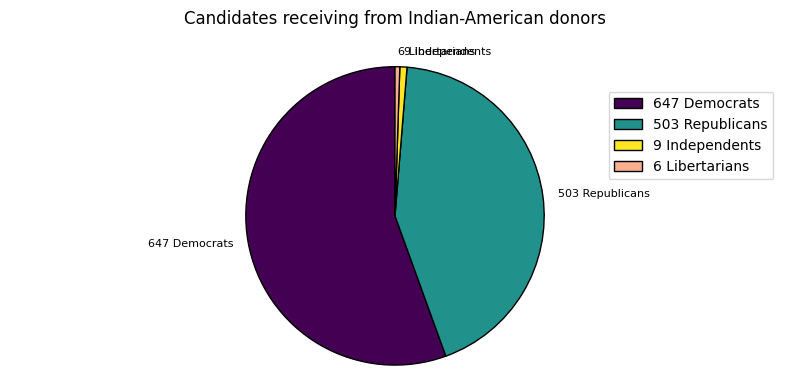

In [ ]:
labels = ['647 Democrats', '503 Republicans', '9 Independents', '6 Libertarians']
sizes = [647, 503, 9, 6]

plt.figure(figsize=(8, 4))
plt.pie(sizes, 
        labels=labels, 
        colors=["#440154", "#21918c", "#fde725", "#fcae91"],
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 8})

plt.title('Candidates receiving from Indian-American donors', pad=20, fontsize=12)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

In [ ]:
receipts_merged = receipts_indian.join(
    receipts.select(["recip_id", "total_amount"]),
    on="recip_id",
    how="inner"
)

receipts_merged = receipts_merged.with_columns(
    (pl.col("total_amount") / 
    pl.col("total_amount_right") * 100)
    .alias("pct_share")
)

receipts_merged.head(10)

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations,total_amount_right,pct_share
str,str,str,str,str,str,str,str,str,str,str,f64,u32,f64,f64
"""P00014530""","""N00029349""","""Michael Bloomberg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,576.0,5,1.0866e9,0.000053
"""P80000722""","""N00001669""","""Joe Biden (D)""","""D""","""PRES""",""" ""","""Y""","""Y""","""C""","""DW""",""" """,5.801522e6,17519,6.81837529e8,0.850866
"""P80001571""","""N00023864""","""Donald Trump (R)""","""R""","""PRES""","""PRES""","""Y""","""Y""","""I""","""RL""",""" """,2.085394e6,5761,4.76382132e8,0.437757
"""P00012716""","""N00044966""","""Tom Steyer (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,22521.0,23,3.2024946e8,0.007032
"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499,1.12206545e8,1.223705
"""S4VT00033""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""","""VTS1""",""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499,1.12206545e8,1.223705
"""P60007168""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""",""" """,""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499,1.12206545e8,1.223705
"""S4VT00033""","""N00000528""","""Bernie Sanders (D)""","""I""","""VTS1""","""VTS1""",""" """,""" ""","""I""","""3I""",""" """,1.373077e6,19499,1.12206545e8,1.223705
"""P00010298""","""N00044183""","""Pete Buttigieg (D)""","""D""","""PRES""",""" """,""" ""","""Y""","""C""","""DL""",""" """,653534.0,2161,8.9972238e7,0.726373


In [ ]:
top_shares = receipts_merged.filter((pl.col("pct_share").is_not_null()) & 
                        (pl.col("pct_share").is_not_nan())
    ).sort(
    pl.col("pct_share"), 
    descending=True
)
top_shares[:10]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations,total_amount_right,pct_share
str,str,str,str,str,str,str,str,str,str,str,f64,u32,f64,f64
"""H8CA48084""","""N00041312""","""Omar Siddiqui (D)""","""D""","""CA48""",""" """,""" """,""" """,""" ""","""DN""",""" """,12000.0,1,12000.0,100.0
"""H0NY05088""","""N00045266""","""Amit Lal (I)""","""I""","""NY05""",""" ""","""Y""","""Y""","""C""","""3L""",""" """,5200.0,1,5200.0,100.0
"""H0CA47158""","""N00045220""","""Shawn Roshan (D)""","""D""","""CA47""",""" """,""" ""","""Y""","""C""","""DN""",""" """,1000.0,2,1000.0,100.0
"""P60008075""","""N00009954""","""Lincoln Chafee (D)""","""D""","""PRES""",""" """,""" """,""" """,""" ""","""DN""",""" """,80000.0,3,80750.0,99.071207
"""H0NC04204""","""N00046241""","""Debesh Sarkar (R)""","""R""","""NC04""",""" """,""" ""","""Y""","""C""","""RL""",""" """,6490.0,4,6740.0,96.290801
"""H8IA03181""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" """,""" ""","""C""","""DC""",""" """,1.222855e6,115,1.514535e6,80.741284
"""S0IA00150""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.222855e6,115,1.514535e6,80.741284
"""H8IA03181""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" """,""" ""","""C""","""DC""",""" """,1.222855e6,115,1.514535e6,80.741284
"""S0IA00150""","""N00041794""","""Eddie J. Mauro (D)""","""D""","""IAS2""",""" """,""" ""","""Y""","""C""","""DL""",""" """,1.222855e6,115,1.514535e6,80.741284


In [ ]:
top_shares[40:50]

id,recip_id,name,party,seat,dummy4,dummy5,dummy6,dummy7,dummy8,dummy9,total_amount,num_donations,total_amount_right,pct_share
str,str,str,str,str,str,str,str,str,str,str,f64,u32,f64,f64
"""H8PA07135""","""N00041179""","""Joe Billie (R)""","""R""","""PA05""",""" """,""" """,""" """,""" ""","""RN""",""" """,239.0,1,1639.0,14.582062
"""H6TX24149""","""N00038290""","""Jan McDowell (D)""","""D""","""TX24""",""" """,""" ""","""Y""","""O""","""DL""",""" """,10000.0,3,74272.0,13.464024
"""H0NY04123""","""N00046428""","""Steve Raiser (R)""","""R""","""NY04""",""" """,""" ""","""Y""","""C""","""RN""",""" """,2800.0,1,20950.0,13.365155
"""H0VA07117""","""N00045174""","""Jason Roberge (R)""","""R""","""VA07""",""" """,""" ""","""Y""","""C""","""RL""",""" """,500.0,2,3750.0,13.333333
"""H4TX18054""","""N00005818""","""Sheila Jackson Lee (D)""","""D""","""TX18""","""TX18""","""Y""","""Y""","""I""","""DW""",""" """,113350.0,82,918772.0,12.33712
"""H4CA12055""","""N00026427""","""Ro Khanna (D)""","""D""","""CA17""","""CA17""","""Y""","""Y""","""I""","""DW""",""" """,413214.0,263,3.48608e6,11.853256
"""H8NJ02216""","""N00042599""","""Hirsch Singh (R)""","""R""","""NJ02""",""" """,""" """,""" ""","""C""","""RL""",""" """,23977.0,27,203225.0,11.798253
"""S0NJ00191""","""N00042599""","""Hirsch Singh (R)""","""R""","""NJS2""",""" """,""" ""","""Y""","""C""","""RL""",""" """,23977.0,27,203225.0,11.798253
"""S8NJ00483""","""N00042599""","""Hirsch Singh (R)""","""R""","""NJS2""",""" """,""" """,""" ""","""C""","""RL""",""" """,23977.0,27,203225.0,11.798253


In [ ]:
df.filter(pl.col("recip_id") == "N00009954")

dummy1,dummy2,contrib_id,name,recip_id,orgname,ultorg,realcode,amount,street,city,state,zip,recipcode,type,gender,occupation,employer,firstname,lastname,name_new,ethnic,region,census_region
i64,i64,str,str,str,str,str,str,f64,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str
2020,4042120201737543451,"""q0000685909 ""","""AMUNDSON, NATHAN""","""N00009954""","""Wisconsin Moss Co""",null,"""Y4000""",250.0,null,"""BABCOCK""","""WI""",54413.0,"""DN""","""15 ""","""M""","""FARMER""","""WISCONSIN MOSS COMPANY""","""nathan""","""amundson""","""nathan amundson""","""not""","""Midwest""","""Great Lakes"""
2020,4042120201737543452,"""r0019544921 ""","""CHAFEE, LINCOLN DAVENPORT""","""N00009954""","""[Candidate Contribution]""",null,"""Z9000""",20000.0,null,"""TETON VILLAGE""","""WY""",83025.0,"""DN""","""15C""","""M""","""RETIRED""","""RETIRED""","""lincoln davenport""","""chafee""","""lincoln davenport chafee""","""ind""","""West""","""Mountain West"""
2020,4022620201694293328,"""r00022804431""","""CASTALDO, RICHARD""","""N00009954""","""Gallup Indian Climic""",null,"""Y4000""",250.0,null,"""GALLUP""","""NM""",87301.0,"""DN""","""15 ""","""M""",null,null,"""richard""","""castaldo""","""richard castaldo""","""not""","""West""","""Mountain West"""
2020,4022620201694293329,"""h30011861551""","""SINGER, DANIEL""","""N00009954""","""Robison Oil""",null,"""E1100""",250.0,null,"""BRIARCLIFF MANOR""","""NY""",10510.0,"""DN""","""15 ""","""M""","""EXECUTIVE""","""ROBISON OIL""","""daniel""","""singer""","""daniel singer""","""not""","""Northeast""","""Mid-Atlantic"""
2020,4022620201694293331,"""r0019544921 ""","""CHAFEE, LINCOLN DAVENPORT""","""N00009954""","""[Candidate Contribution]""",null,"""Z9000""",10000.0,null,"""TETON VILLAGE""","""WY""",83025.0,"""DN""","""15C""","""M""","""RETIRED""","""RETIRED""","""lincoln davenport""","""chafee""","""lincoln davenport chafee""","""ind""","""West""","""Mountain West"""
2020,4022620201694293332,"""r0019544921 ""","""CHAFEE, LINCOLN DAVENPORT""","""N00009954""","""[Candidate Contribution]""",null,"""Z9000""",50000.0,null,"""TETON VILLAGE""","""WY""",83025.0,"""DN""","""15C""","""M""","""RETIRED""","""RETIRED""","""lincoln davenport""","""chafee""","""lincoln davenport chafee""","""ind""","""West""","""Mountain West"""
